<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1><h1>Pre-trained-Models with PyTorch </h1>

In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>

<h2 id="download_data">Download Data</h2>

Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:

In [1]:
#!curl https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip -o Positive_tensors.zip 

In [2]:
#!curl https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip -o Negative_tensors.zip

In [3]:
import os
print(os.getcwd())
print(os.listdir())

C:\Users\Sudhish Kumar\Desktop\AI_Capstone
['.ipynb_checkpoints', '1.0_load_and_display_data.ipynb', '2.1_data_loader_PyTorch.ipynb', '4.1_resnet18_PyTorch.ipynb', '5.4softmax_in_one_dimension_v2.ipynb', 'classifier_resnet_model.h5', 'concrete_crack_images_for_classification', 'concrete_crack_images_for_classification.zip', 'concrete_data_week3', 'concrete_data_week3.zip', 'DL0321EN-3-1-Pretrained-Models-py-v1.0.ipynb', 'Negative_tensors', 'Negative_tensors.zip', 'Positive_tensors', 'Positive_tensors.zip', 'resources', 'temp', 'wget-1.20.3-win64', 'wget-1.20.3-win64.zip', '__MACOSX']


In [4]:
# Using zipFile to unzip instead
import zipfile
#with zipfile.ZipFile('Positive_tensors.zip', 'r') as zip_ref:
#    zip_ref.extractall(os.getcwd())

#with zipfile.ZipFile('Negative_tensors.zip', 'r') as zip_ref:
#    zip_ref.extractall(os.getcwd())
    

We will install torchvision:

In [5]:
!pip install torchvision

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [6]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [7]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

In [8]:
work_dir=os.getcwd()

<h2 id="data_class">Dataset Class</h2>

 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.

In [9]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory=work_dir
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [10]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>

<b>Prepare a pre-trained resnet18 model :</b>

<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [56]:
# Step 1: Load the pre-trained model resnet18
model=models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [57]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
model.requires_grad_=False


<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [58]:
original_input_features=model.fc.in_features
model.fc=nn.Linear(original_input_features,2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [59]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>

In this question you will train your, model:

<b>Step 1</b>: Create a cross entropy criterion function 

In [60]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [61]:
train_loader = DataLoader(train_dataset, batch_size=100)
validation_loader=DataLoader(validation_dataset, batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [62]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**

In [63]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
print("N_test = {}".format(N_test))

N_train=len(train_dataset)
print("N_train = {}".format(N_train))
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    counter=0
    for x, y in train_loader:
        print("Batch {} of training".format(counter))
        # model train
        model.train() 
        # clear gradient
        optimizer.zero_grad()
        # make a prediction
        yhat=model(x)

        # calculate loss 
        loss=criterion(yhat, y)
        # calculate gradients of parameters
        loss.backward()
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        counter+=1

    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval
        model.eval()
        #make a prediction
        prediction=model(x_test)
        # find max 
        _,yhat=torch.max(prediction,1)
        print(type(yhat))
        # find max 
        #Calculate misclassified  samples in mini-batch 
        accuracy_list+=list(map(int,[y1==y2 for y1,y2 in zip(yhat,y_test)]))
        
    correct=sum(accuracy_list)
    accuracy=correct/N_test


N_test = 10000
N_train = 30000
Batch 0 of training
Batch 1 of training
Batch 2 of training
Batch 3 of training
Batch 4 of training
Batch 5 of training
Batch 6 of training
Batch 7 of training
Batch 8 of training
Batch 9 of training
Batch 10 of training
Batch 11 of training
Batch 12 of training
Batch 13 of training
Batch 14 of training
Batch 15 of training
Batch 16 of training
Batch 17 of training
Batch 18 of training
Batch 19 of training
Batch 20 of training
Batch 21 of training
Batch 22 of training
Batch 23 of training
Batch 24 of training
Batch 25 of training
Batch 26 of training
Batch 27 of training
Batch 28 of training
Batch 29 of training
Batch 30 of training
Batch 31 of training
Batch 32 of training
Batch 33 of training
Batch 34 of training
Batch 35 of training
Batch 36 of training
Batch 37 of training
Batch 38 of training
Batch 39 of training
Batch 40 of training
Batch 41 of training
Batch 42 of training
Batch 43 of training
Batch 44 of training
Batch 45 of training
Batch 46 of t

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>

In [64]:
accuracy

0.9984

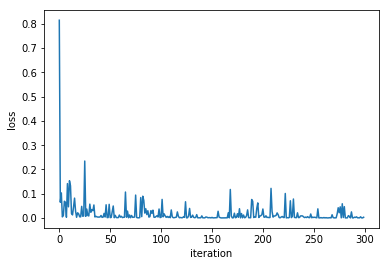

In [65]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 

<b>Identify the first four misclassified samples using the validation data:</b>

In [66]:
# all misclassified images will have accuracy value of 0 in the accuracy_list
misclassified_image_index=[idx for idx,val in enumerate(accuracy_list) if val == 0]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


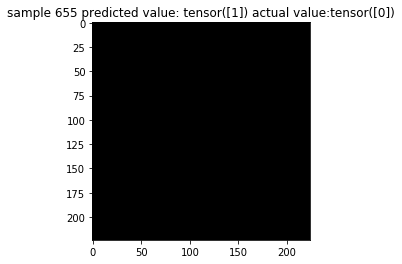

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


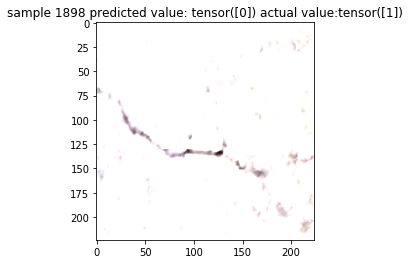

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


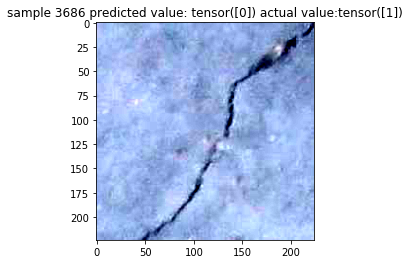

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


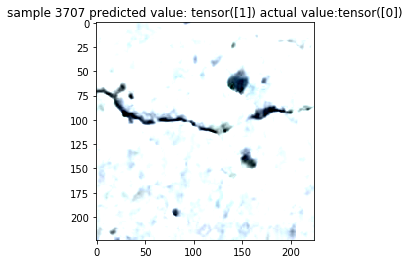

In [69]:
# first four misclassified images 
for idx in range(4):
    sample_idx=misclassified_image_index[idx]
    image,y = validation_dataset[sample_idx]
    x=image.unsqueeze(0)
    y=y.unsqueeze(0)
    prediction=model(x)
    _,yhat=torch.max(prediction,1)
    plt.title("sample {} predicted value: {} actual value:{}".format(sample_idx,yhat,y))    
    #plt.title("Image {} misclassified".format(idx))
    plt.imshow(image.permute(1,2,0))
    plt.show()

<!--- --->

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.